In [1]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import error_analysis
from utils.analysis_tools_lazimpa import load_accuracies_lazimpa, load_entropies_by_setting, plot_frequency_x_message_length

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [2]:
datasets = ('(3,4)', '(3,8)', '(4,4)')
n_attributes = (3, 3, 4)
n_values = (4, 8, 4)
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3/' for d in datasets]

In [46]:
datasets = ['(3,4)', ]
n_values = [4,]
n_attributes = [3, ]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated
lazy = True # whether the lazy agent is used
impatient = True
setting = ""
if not lazy:
    start = 'impatience_' if impatient else ''
    if context_unaware:
        setting = start + 'context_unaware'
    else:
        setting = start + 'context_aware'
        if impatient == False:
            setting = 'standard'
else:
    start = 'lazimpa' if impatient else 'lazy'
    if context_unaware:
        setting = start + '_context_unaware'
    else:
        setting = start + '_context_aware'
setting

'lazimpa_context_aware'

## Accuracies

### Training trajectories

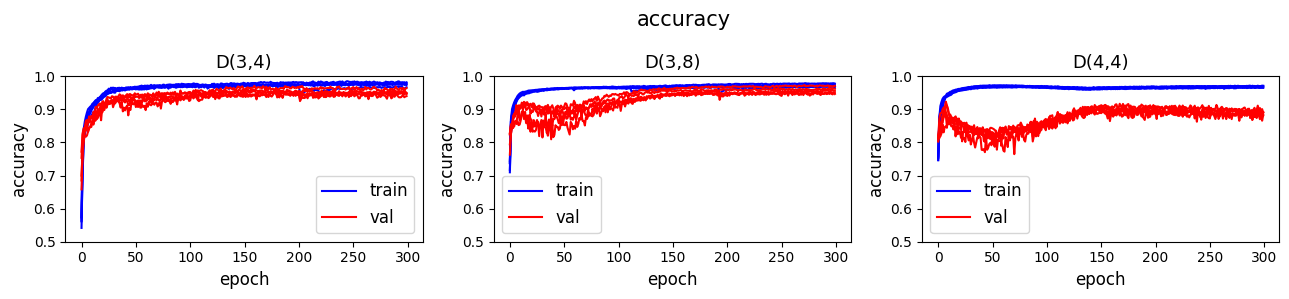

In [12]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
plot_training_trajectory(all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc'], ylim=(0.5, 1), steps=(1, 1), plot_shape=(1,3), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'),figsize=(13, 3),plot_indices=(1,2,3))

### Learning speed

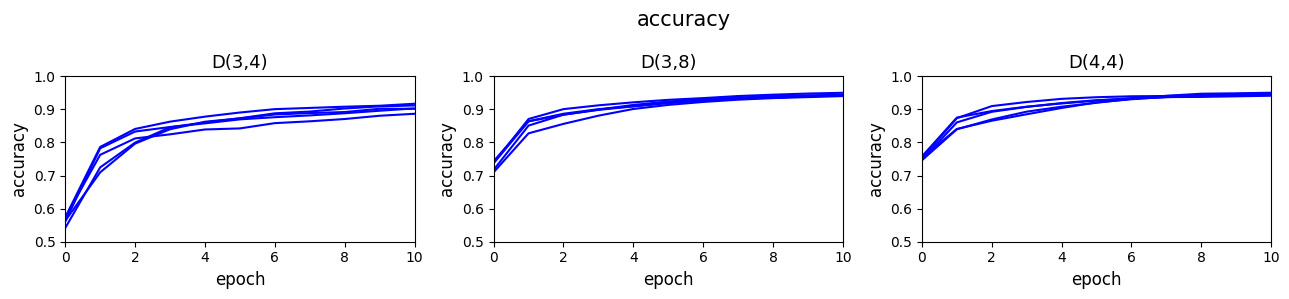

In [13]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
plot_training_trajectory(all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc'], ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), train_only=True, plot_shape=(1,3), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'),figsize=(13, 3),plot_indices=(1,2,3)) 

### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [5]:
all_accuracies = load_accuracies_lazimpa(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=False,lazimpa=True)
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc'],
              all_accuracies['lazimpa_train_acc'], all_accuracies['lazimpa_val_acc']]
test_accuracies = [all_accuracies['test_acc'], all_accuracies['lazimpa_test_acc']]

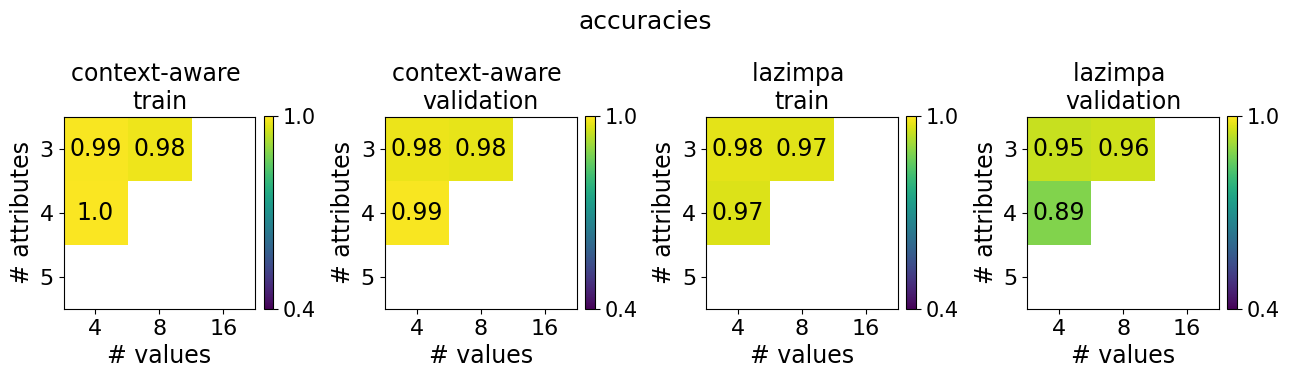

In [17]:

plot_heatmap(accuracies, 'mean', plot_dims=(1,4), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', 
             fontsize=17, matrix_indices=((0,0), (0,1), (1,0)), titles=('context-aware \ntrain', 'context-aware \nvalidation', 'lazimpa \ntrain', 'lazimpa \nvalidation'))

#### LazImpa

In [9]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['lazimpa_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.976, 0.005), '(3,8)': (0.972, 0.004), '(4,4)': (0.969, 0.002)}

In [10]:
# lazimpa
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['lazimpa_val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.95, 0.008), '(3,8)': (0.957, 0.009), '(4,4)': (0.887, 0.004)}

#### Context-aware

In [11]:

final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.993, 0.003), '(3,8)': (0.984, 0.006), '(4,4)': (0.995, 0.003)}

In [12]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.983, 0.004), '(3,8)': (0.977, 0.006), '(4,4)': (0.993, 0.005)}

#### Accuracies: Boostrapped CIs

In [6]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# context-aware (train, val), lazimpa (train, val)
for i in range(len(accuracies)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies[i]) for _ in range(len(accuracies[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

Bootstrap Confidence Interval (95.0%): (0.9738715597391129, 0.9845829124053319), Mean: 0.9785301127387418
Bootstrap Confidence Interval (95.0%): (0.9631263401110967, 0.9821836848788791), Mean: 0.9737742642664644
Bootstrap Confidence Interval (95.0%): (0.9631263401110967, 0.9821836848788791), Mean: 0.9706601558519293
Bootstrap Confidence Interval (95.0%): (0.8931968725654814, 0.9821836848788791), Mean: 0.9568266812293827


### Test accuracies
means and stds

In [15]:
test_accuracies


[array([[0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.63679951, 0.78210992, 0.73057991, 0.66146594, 0.61986005],
        [0.86967105, 0.97659606, 0.90132159, 0.98230481, 0.98235208]]),
 array([[0.75921154, 0.804317  , 0.75239319, 0.81156331, 0.80687499],
        [0.68995762, 0.70863867, 0.6653561 , 0.66140258, 0.71734947],
        [0.84349382, 0.87468827, 0.83738703, 0.83078647, 0.87515491]])]

In [16]:
# first context-aware, then lazimpa
for cond in test_accuracies:
    for i, d in enumerate(datasets):
        print(d, round(np.mean(cond[i]), 3), round(np.std(cond[i]), 3), round(np.min(cond[i]), 2), round(np.max(cond[i]), 2))

(3,4) 0.784 0.035 0.73 0.83
(3,8) 0.686 0.061 0.62 0.78
(4,4) 0.942 0.048 0.87 0.98
(3,4) 0.787 0.026 0.75 0.81
(3,8) 0.689 0.022 0.66 0.72
(4,4) 0.852 0.019 0.83 0.88


## ZLA significance

In [12]:
# Mean 
results_dict = {'mean_length':[],'mean_weighted_length':[],'p_ZLA':[]}

for path_idx, path in enumerate(paths):
    mean_length, mean_weighted_length, p_zla = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + setting + '/' + str(run) + '/ZLA_significance.pkl', 'rb'))
        print(data)
        mean_length.append(data['mean_message_length'])
        mean_weighted_length.append(data['mean_weighted_message_length'])
        p_zla.append(data['p_zla'])

    results_dict['mean_length'].append(mean_length)
    results_dict['mean_weighted_length'].append(mean_weighted_length)
    results_dict['p_ZLA'].append(p_zla)

# Average for each dataset
print("LazImpa")
print("Average Message length")
positional_encoding_array = [np.array(s) for s in results_dict['mean_length']]
[print("D",d, np.nanmean(s,axis=0),np.nanstd(s,axis=0)) for s,d in  zip(positional_encoding_array,datasets)]

print("Average Effective length")
[print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['effective_length'],datasets)]
print("Average Information Density")
_ = [print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['information_density'],datasets)]

{'mean_message_length': 1.9174312353134155, 'mean_weighted_message_length': 1.1197502613067627, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 1.90816330909729, 'mean_weighted_message_length': 1.2337443828582764, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 1.8613861799240112, 'mean_weighted_message_length': 1.081712007522583, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 1.8494623899459839, 'mean_weighted_message_length': 1.044843077659607, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 1.881188154220581, 'mean_weighted_message_length': 1.2083792686462402, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 2.013157844543457, 'mean_weighted_message_length': 1.4848201274871826, 'p_zla': 0.0, 'min_bool_value': False, 'max_bool_value': False}
{'mean_message_length': 2.1449999809265137, 'm

results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/0/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/1/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/2/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/3/interactions/train/epoch_300/interaction_gpu0
results/(3,4)_game_size_10_vsf_3//lazimpa_context_aware/4/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/0/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/1/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/2/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/3/interactions/train/epoch_300/interaction_gpu0
results/(3,8)_game_size_10_vsf_3//lazimpa_context_aware/4/intera

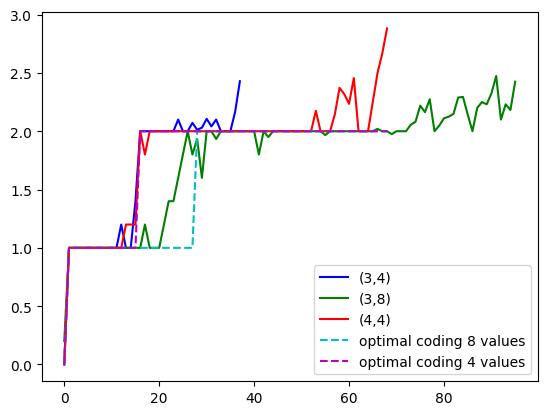

In [4]:
# plot frequency x mean
plot_frequency_x_message_length(paths,setting,n_runs,n_values,datasets,n_epochs)

## Information analysis

#### LazImpa

In [14]:
results_dict = {'positional_encoding':[],'effective_length':[],'information_density':[]}

for path_idx, path in enumerate(paths):
    pe, el, id = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + setting + '/' + str(run) + '/symbol_informativeness.pkl', 'rb'))
        pe.append(data['positional_encoding'])
        el.append(data['effective_length'])
        id.append(data['information_density'])

    results_dict['positional_encoding'].append(pe)
    results_dict['effective_length'].append(el)
    results_dict['information_density'].append(id)

# Average for each dataset
print("LazImpa")
print("Average Positional Encoding")
positional_encoding_array = [np.array(s) for s in results_dict['positional_encoding']]
[print("D",d, np.nanmean(s,axis=0),np.nanstd(s,axis=0)) for s,d in  zip(positional_encoding_array,datasets)]

print("Average Effective length")
[print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['effective_length'],datasets)]
print("Average Information Density")
_ = [print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['information_density'],datasets)]

LazImpa
Average Positional Encoding
D (3,4) [0.96843739 0.94585348 0.8888889 ] [0.00948684 0.00503019 0.14054567]
D (3,8) [0.98514394 0.93920158 0.87920595] [0.00597135 0.00488992 0.0403748 ]
D (4,4) [0.91675754 0.93318326 0.87582389 1.        ] [0.01060374 0.00474006 0.04527797 0.        ]
Average Effective length
D (3,4) 1.095638930797577 0.07496725269198531
D (3,8) 1.4258249998092651 0.12254082122912442
D (4,4) 1.0048502802848815 0.052684606728419486
Average Information Density
D (3,4) 0.9627545356750489 0.006352516856370982
D (3,8) 0.9680464148521424 0.0029678946796319176
D (4,4) 0.9199480414390564 0.009239078936446862


#### Standard context-aware agent

In [15]:
results_dict = {'positional_encoding':[],'effective_length':[],'information_density':[]}

for path_idx, path in enumerate(paths):
    pe, el, id = [], [], []

    for run in range(n_runs):
        data = pickle.load(open(path + '/' + "standard"+ '/' + str(run) + '/symbol_informativeness.pkl', 'rb'))
        pe.append(data['positional_encoding'])
        el.append(data['effective_length'])
        id.append(data['information_density'])

    results_dict['positional_encoding'].append(pe)
    results_dict['effective_length'].append(el)
    results_dict['information_density'].append(id)

# Average for each dataset
print("Standard")
print("Average Positional Encoding")
positional_encoding_array = [np.array(s) for s in results_dict['positional_encoding']]
[print("D",d, np.nanmean(s,axis=0),np.nanstd(s,axis=0)) for s,d in  zip(positional_encoding_array,datasets)]

print("Average Effective length")
[print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['effective_length'],datasets)]
print("Average Information Density")
_ = [print("D",d, np.nanmean(s),np.std(s)) for s,d in  zip(results_dict['information_density'],datasets)]

Standard
Average Positional Encoding
D (3,4) [0.99243189 0.92423536 0.76565851] [0.00166666 0.02530473 0.06035826]
D (3,8) [0.99838803 0.97743719 0.91005291] [0.00075547 0.00136665 0.02646579]
D (4,4) [0.99843229 0.97314627 0.88646855 0.7759366 ] [0.00077242 0.00483249 0.01886843 0.02813924]
Average Effective length
D (3,4) 2.682325839996338 0.0838200901147946
D (3,8) 2.8858781337738035 0.02696189657820316
D (4,4) 3.6339837551116942 0.031555359262648595
Average Information Density
D (3,4) 0.8941085934638977 0.027940038359686104
D (3,8) 0.9619593739509582 0.008987309175228123
D (4,4) 0.9084959387779236 0.007888839815662149


## Entropy scores

In [4]:
entropy_scores = load_entropies_by_setting(paths, setting = 'lazimpa_context_aware')
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

d:\Documents\GitHub\emergent-abstractions\utils\analysis_tools_lazimpa.py:605: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### General

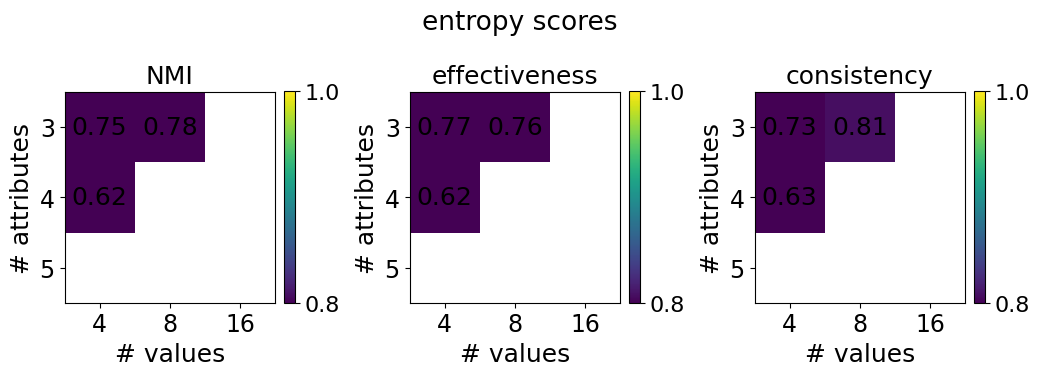

In [18]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5),
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores',  matrix_indices=((0,0), (0,1), (1,0)))

#### Means and stds

In [19]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.75, 0.027),
 '(3,8)NMI': (0.783, 0.039),
 '(4,4)NMI': (0.624, 0.033),
 '(3,4)effectiveness': (0.77, 0.028),
 '(3,8)effectiveness': (0.76, 0.033),
 '(4,4)effectiveness': (0.621, 0.048),
 '(3,4)consistency': (0.731, 0.027),
 '(3,8)consistency': (0.807, 0.047),
 '(4,4)consistency': (0.629, 0.018)}

#### Bootstraped CIs

In [20]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for i in range(len(entropies)):
    score = list(entropy_scores.keys())[i]
    for idx, d in enumerate(datasets):
        for _ in range(num_bootstrap_samples):
            bootstrap_sample = [random.choice(entropies[i][idx]) for _ in range(len(entropies[i][idx]))]
            bootstrap_mean = np.mean(bootstrap_sample)
            bootstrap_means.append(bootstrap_mean)

        # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
        alpha = (1 - confidence_level) / 2
        lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
        upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
        #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
        entropies_bootstrapped[d + score] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped

{'(3,4)NMI': ((0.73, 0.77), 0.75),
 '(3,8)NMI': ((0.73, 0.81), 0.77),
 '(4,4)NMI': ((0.6, 0.81), 0.72),
 '(3,4)effectiveness': ((0.6, 0.8), 0.73),
 '(3,8)effectiveness': ((0.61, 0.8), 0.74),
 '(4,4)effectiveness': ((0.6, 0.8), 0.72),
 '(3,4)consistency': ((0.6, 0.8), 0.72),
 '(3,8)consistency': ((0.6, 0.83), 0.73),
 '(4,4)consistency': ((0.6, 0.83), 0.72)}

### concept-level

#### Bootstrapping CIs: Concept-level

#### Plotting Concept-level

In [11]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}

In [13]:
all_hierarchical = {}
all_hierarchical['metric'] = ['Effectiveness'] * 75 + ['Consistency'] * 75 + ['NMI'] * 75 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

C:\Users\eosan\AppData\Local\Temp\ipykernel_11004\532188238.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),


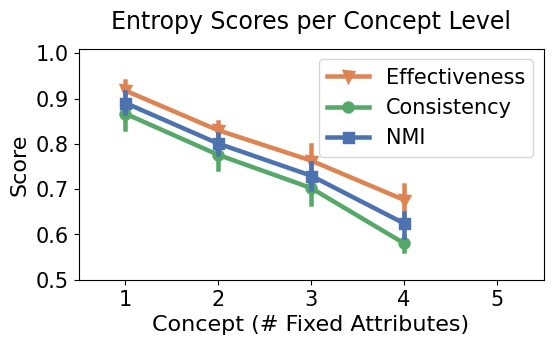

In [16]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Concept Level', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.5,0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')
plt.show()

#### Bootstrapping

In [19]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [20]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [21]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [1, 2, 3, 4, 5]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,3), round(upper_percentile,3)), round(np.mean(bootstrap_means),3)
entropies_bootstrapped
    

c:\Users\eosan\anaconda3\envs\emergab\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eosan\anaconda3\envs\emergab\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{1: ((0.866, 0.914), 0.891),
 2: ((0.781, 0.911), 0.846),
 3: ((0.707, 0.908), 0.807),
 4: ((0.606, 0.907), 0.762),
 5: ((nan, nan), nan)}

### Context-dependent

In [24]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_context_dep

{'(3,4)NMI_context_dep': array([0.77274387, 0.82432607, 0.85086291]),
 '(3,8)NMI_context_dep': array([0.80830677, 0.82376594, 0.84026697]),
 '(4,4)NMI_context_dep': array([0.68015863, 0.71147708, 0.74175036, 0.75943915]),
 '(3,4)effectiveness_context_dep': array([0.71254021, 0.8372327 , 0.9245175 ]),
 '(3,8)effectiveness_context_dep': array([0.76408278, 0.79398846, 0.79814282]),
 '(4,4)effectiveness_context_dep': array([0.629002  , 0.68478019, 0.7472373 , 0.80280223]),
 '(3,4)consistency_context_dep': array([0.84519019, 0.81213666, 0.78846022]),
 '(3,8)consistency_context_dep': array([0.85812772, 0.85606102, 0.88756285]),
 '(4,4)consistency_context_dep': array([0.74303073, 0.74189348, 0.7367876 , 0.72059292])}

#### Bootstrapping CIs: Context

In [23]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [26]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [0, 1, 2, 3, 4]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped
    

c:\Users\eosan\anaconda3\envs\emergab\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eosan\anaconda3\envs\emergab\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0: ((0.72, 0.79), 0.75),
 1: ((0.73, 0.81), 0.77),
 2: ((0.73, 0.83), 0.78),
 3: ((0.73, 0.83), 0.78),
 4: ((nan, nan), nan)}

#### Plotting per Context condition

In [27]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [28]:
all_context_dep = {}
all_context_dep['metric'] = ['Effectiveness'] * 75 + ['Consistency'] * 75 +['NMI'] * 75
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

C:\Users\eosan\AppData\Local\Temp\ipykernel_11004\1236495869.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),


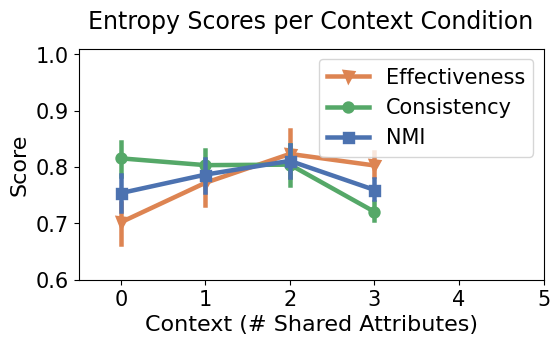

In [31]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Context Condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4,5], labels=[0,1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')
plt.show()

### Concept x Context

In [37]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

d:\Documents\GitHub\emergent-abstractions\utils\plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
d:\Documents\GitHub\emergent-abstractions\utils\plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
d:\Documents\GitHub\emergent-abstractions\utils\plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


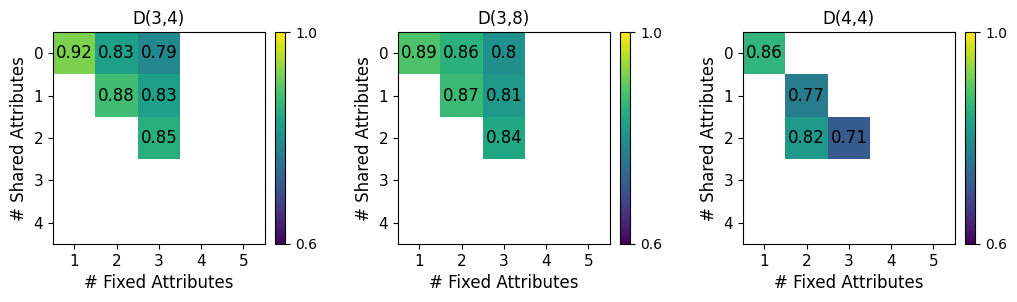

In [35]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(1,3), heatmap_size=(5,5), 
                                figsize=(10.5, 3), fontsize = 12, titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

## Message length

In [7]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

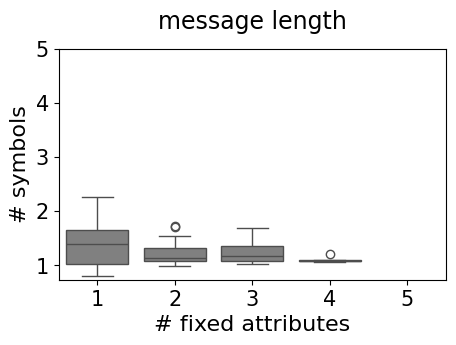

In [8]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5],fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

## Symbol redundancy

In [9]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

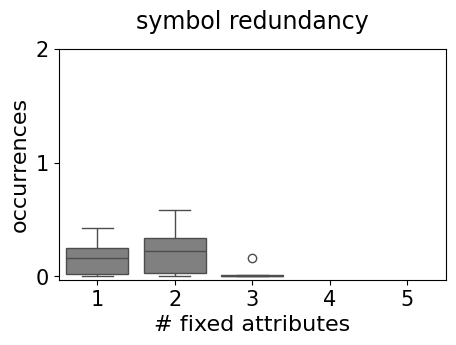

In [10]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Compositionality

In [11]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        posdis_generic[d, run] = disent_score['posdis_generic']
        bosdis_generic[d, run] = disent_score['bosdis_generic']

### Topsim

In [12]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.194 sd 0.02
(3,8) topsim: 0.094 sd 0.0
(4,4) topsim: 0.138 sd 0.01


### Compositionality per dataset

In [17]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

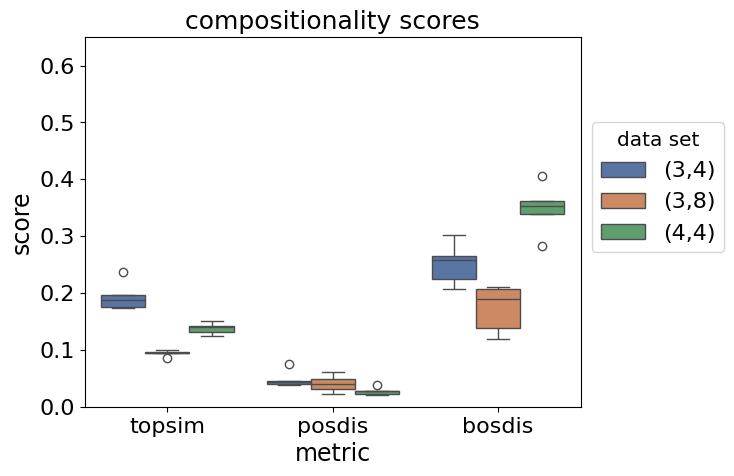

In [18]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

## Errors

In [19]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [20]:
import torch
from utils.analysis_from_interaction import *

In [22]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [23]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)
1 (3,8)
2 (4,4)


In [24]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

In [25]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 54, (1, 1): 124, (0, 1): 11, (0, 0): 17, (1, 2): 2}

In [26]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

{(2, 2): 19, (1, 1): 30, (0, 1): 2, (0, 0): 3, (1, 2): 2}

In [27]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 136, (1, 2): 129, (2, 2): 125, (0, 0): 27, (0, 1): 85, (1, 1): 101}

In [28]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(1, 2)
2 129 0.015503875968992248
2 0.015503875968992248
(2, 2)
54 125 0.432
54 0.432
(0, 0)
17 27 0.6296296296296297
1 0.037037037037037035
(0, 1)
11 85 0.12941176470588237
0 0.0
(1, 1)
124 101 1.2277227722772277
26 0.25742574257425743
(3,8)
(2, 2)
574 1004 0.5717131474103586
554 0.5517928286852589
(0, 0)
121 57 2.1228070175438596
25 0.43859649122807015
(0, 1)
164 351 0.4672364672364672
11 0.03133903133903134
(1, 1)
476 392 1.2142857142857142
198 0.5051020408163265
(0, 2)
5 1047 0.004775549188156638
5 0.004775549188156638
(1, 2)
69 1037 0.0665380906460945
59 0.05689488910318226
(4,4)
(1, 2)
45 500 0.09
1 0.002
(3, 3)
206 504 0.4087301587301587
206 0.4087301587301587
(2, 3)
25 544 0.04595588235294118
25 0.04595588235294118
(0, 3)
(1, 1)
59 184 0.32065217391304346
29 0.15760869565217392
(0, 1)
1 185 0.005405405405405406
0 0.0
(0, 2)
102 525 0.19428571428571428
0 0.0
(2, 2)
252 509 0.4950884086444008
178 0.34970530451866405
(1, 3)
(0, 0)
85 41 2.073170731707317
8 0.195121951

In [29]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [30]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [31]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [32]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

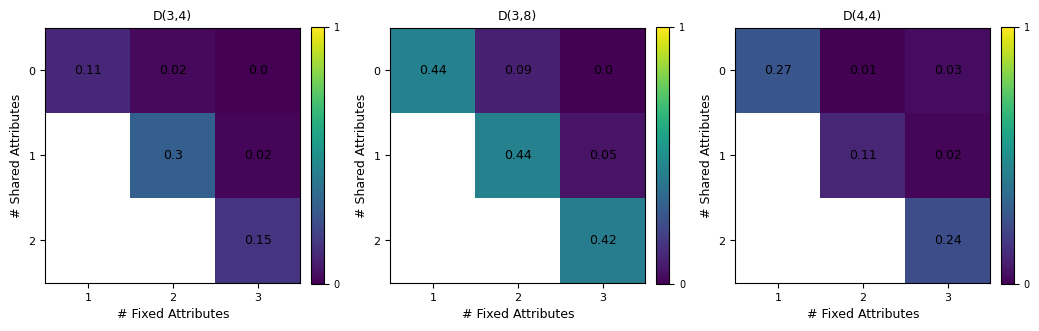

In [38]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(3,3), 
                                figsize=(10.5, 7), fontsize = 9, plot_dims=(1, 3),
                                datasets = ['(3,4)', '(3,8)', '(4,4)'],
                                titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

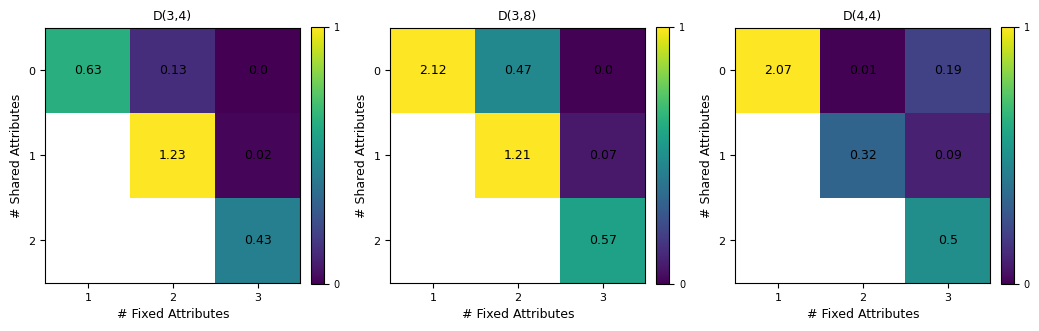

In [41]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(3,3), 
                                figsize=(10.5, 7), fontsize = 9, plot_dims=(1, 3),
                                datasets = ['(3,4)', '(3,8)', '(4,4)'],
                                titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

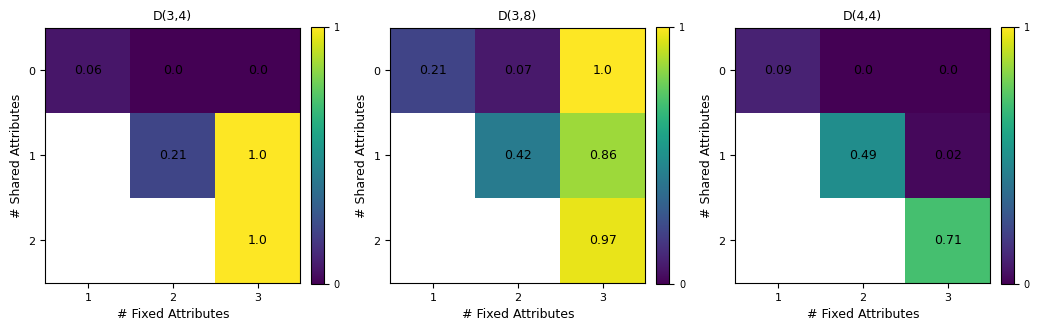

In [42]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(3,3), 
                                figsize=(10.5, 7), fontsize = 9, plot_dims=(1, 3),
                                datasets = ['(3,4)', '(3,8)', '(4,4)'],
                                titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

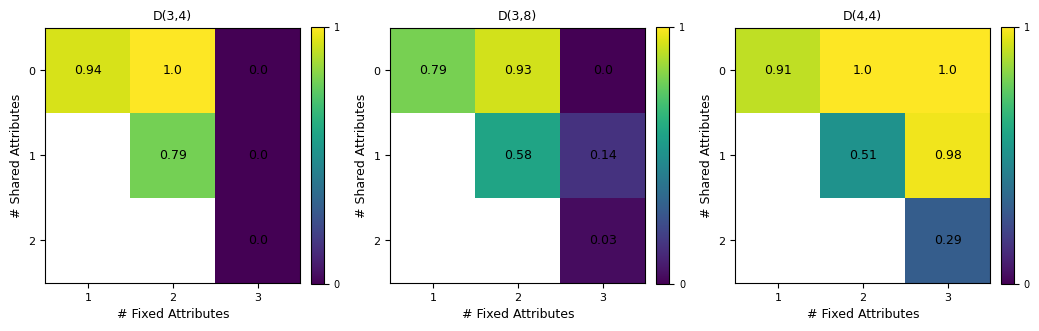

In [43]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(3,3), 
                                figsize=(10.5, 7), fontsize = 9, plot_dims=(1, 3),
                                datasets = ['(3,4)', '(3,8)', '(4,4)'],
                                titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))